# Introduction

We are working for a car insurance provider who would like to predict whether a client will submit a claim or not, and identify which factors offer contribute the most to this predictive capability.  With this information, we would be able to complete some back of the envelope math to calculate how many dollars we are likely to pay out in claims this year, and gain insight into the variables with the greatest predictive power so we can further tailor coverage packages and premiums to individual drivers.    

---- talk about the models leading up to the best.  Maybe show snapshot of results, what was done differently, what some problem may have been.... then get to the best model and talk about what we can do with it, what does it tell us... it tells us that we ultimately need more or different data to achieve our goal.  

---- what visuals to use and talk about? 


this notebook up-sampling only using resample

**Data Dictionary**

- pol_eff_dt - auto insurance policy effective date
- gender - gender of driver: F, M
- agecat - driver's age category: 1 (youngest), 2, 3, 4, 5, 6
- credit_score - driver’s credit score(integer): 1-100, 1=poor, 100=excellent
- area - driver's area of residence: A, B, C, D, E, F
- traffic_index - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average
- veh_age - age of vehicle(categorical): 1 (youngest), 2, 3, 4
- veh_body - vehicle body, coded as:
    - BUS
    - CONVT = convertible  
    - COUPE   
    - HBACK = hatchback                  
    - HDTOP = hardtop
    - MCARA = motorized caravan
    - MIBUS = minibus
    - PANVN = panel van
    - RDSTR = roadster
    - SEDAN    
    - STNWG = station wagon
    - TRUCK           
    - UTE = utility
- veh_value - vehicle value, in \\$10,000s
- claim_office - office location of claim handling agent: A, B, C, D
- traffic2 - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average.  Null values have imputed mean of full dataset
- veh_value2 - vehicle value, in \\$10,000s. Null values have been replaces with the mean of the full dataset
- veh_value3 - vehicle value, in \\$10,000s. Null values have been replaces with the median of the full dataset
- veh_age2 - age of vehicle(categorical): 1 (youngest), 2, 3, 4.  Null values have been replaces with the most frequent category, which is 2
- credit2 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the mean of the full dataset
- credit3 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the median of the full dataset
- dob - driver's date of birth
- age - Driver's age at policy effective date
- claim_ind - Indicates if the policy had a claim (=1) or not
- veh_body2 - vehicle body, with a collapsed type coding, as described below.  Original coding on left, new coding on right:
    - 'BUS' = 'MIBUS',
    - 'CONVT' = 'HDTOP'
    - 'COUPE' = 'COUPE'
    - 'HBACK' = 'HBACK'
    - 'HDTOP' = 'HDTOP'
    - 'MCARA' = 'MIBUS'
    - 'MIBUS' = 'MIBUS'
    - 'PANVN' = 'PANVN'
    - 'RDSTR' = 'HDTOP'
    - 'SEDAN' = 'SEDAN'
    - STNWG' = 'STNWG'
    - 'TRUCK' = 'TRUCK'
    - 'UTE' = 'UTE'

- numclaims - number of claims(integer): 0 if no claim
- claimcst0 - claim amount: 0 if no claim.  This is the total one year claim amount (ultimate loss) for the policy. 


# Obtaining the Data

In [68]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import pandas_profiling

import itertools

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels # for confusion matrix

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import copy

In [69]:
data = pd.read_csv('autoinsurance_claims.csv')
data.head()

,pol_number,pol_eff_dt,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,traffic2,veh_value2,veh_value3,veh_age2,credit2,credit3,dob,age,claim_ind,veh_body2,numclaims,claimcst0
0,80750205,7/1/2015,M,4,52.0,C,93.0,4.0,STNWG,2.96,NaN,93,2.96,2.96,4,52.000000,52,2/18/1963,53,0,STNWG,0,0.0
1,90994433,8/1/2015,M,3,83.0,C,108.0,4.0,SEDAN,1.89,NaN,108,1.89,1.89,4,83.000000,83,2/18/1978,38,0,SEDAN,0,0.0
2,59239520,7/1/2015,M,5,71.0,A,NaN,3.0,SEDAN,2.75,NaN,100,2.75,2.75,3,71.000000,71,4/14/1960,56,0,SEDAN,0,0.0
3,67030771,11/1/2015,M,3,NaN,B,77.0,3.0,UTE,2.92,NaN,77,2.92,2.92,3,74.730883,81,12/23/1974,41,0,UTE,0,0.0
4,91422215,8/1/2015,M,2,88.0,D,NaN,4.0,STNWG,3.63,NaN,100,3.63,3.63,4,88.000000,88,12/25/1984,31,0,STNWG,0,0.0


In [70]:
data.shape

(60948, 23)

# Preprocessing

In [71]:
# looking for null values
data.isnull().sum()

pol_number           0
pol_eff_dt           0
gender               0
agecat               0
credit_score      3014
area                 0
traffic_index    12250
veh_age          10476
veh_body             0
veh_value         7562
claim_office     56787
traffic2             0
veh_value2           0
veh_value3           0
veh_age2             0
credit2              0
credit3              0
dob                  0
age                  0
claim_ind            0
veh_body2            0
numclaims            0
claimcst0            0
dtype: int64

__Dropping Columns__

In [72]:
# claim office is mostly empty; lets drop the feature
# we don't need the policy number either
# veh_body and veh_body2 are equal, keep veh_body2 as it is updated
# the dateTime columns create a complexity we could do without and tell us nothing since they are not the focus
  ## of the data.
# pol_eff_dt is proprietary info we don't need and dob is redundant since we have age. 
  
data.drop(['claim_office', 'pol_number', 'veh_body', 'pol_eff_dt', 'dob'], axis = 1, inplace = True)

there are duplicate columns for credit_score, traffic_index, vehicle_value, containing null values, where either the mean, median or both were used to impute missing values.  Lets keep only columns with median imputation

In [73]:
# drop credit_score and credit2 columns
# drop veh_age column.  vehicle age also has a duplicate column, where the mode was used for null values. 
  ##This is an ordinal value so keeping the mode for imputation makes sense
data.drop(['credit_score', 'credit2', 'traffic_index', 'veh_value', 'veh_value2', 'veh_age'], axis = 1, inplace = True)

In [74]:
# confirm we have no other null values
data.isnull().sum()

gender        0
agecat        0
area          0
traffic2      0
veh_value3    0
veh_age2      0
credit3       0
age           0
claim_ind     0
veh_body2     0
numclaims     0
claimcst0     0
dtype: int64

**Fix Data Types**

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null object
agecat        60948 non-null int64
area          60948 non-null object
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null int64
veh_body2     60948 non-null object
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: float64(2), int64(7), object(3)
memory usage: 5.6+ MB




| Feature | Change Type to: |
|------------|---------------------|
| gender | change to category |
| agecat | change to category |
| area | change to category |
| veh_age2 | change to category |
| claim_ind | change to category |
| veh_body2 | change to category |


In [76]:
data = data.astype({'gender':'category', 'area':'category', 
             'claim_ind':'category', 'veh_body2':'category'}, inplace = True)

In [77]:
# double check the work
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null category
agecat        60948 non-null int64
area          60948 non-null category
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null category
veh_body2     60948 non-null category
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: category(4), float64(2), int64(6)
memory usage: 4.0 MB


**Edit Column Names**

Lets change a few of the column names for ease of use as we move forward and work with the data

In [78]:
data.rename(columns={'traffic2':'traffic_index', 'veh_value3':'veh_value00', 'credit3':'credit_score', 'numclaims':'num_claims', 
             'claimcst0':'claim_amount', 'veh_age2':'veh_ageIndex'}, inplace=True)

In [79]:
data.to_csv('clean_data.csv')

**Look for Multicolinearity**

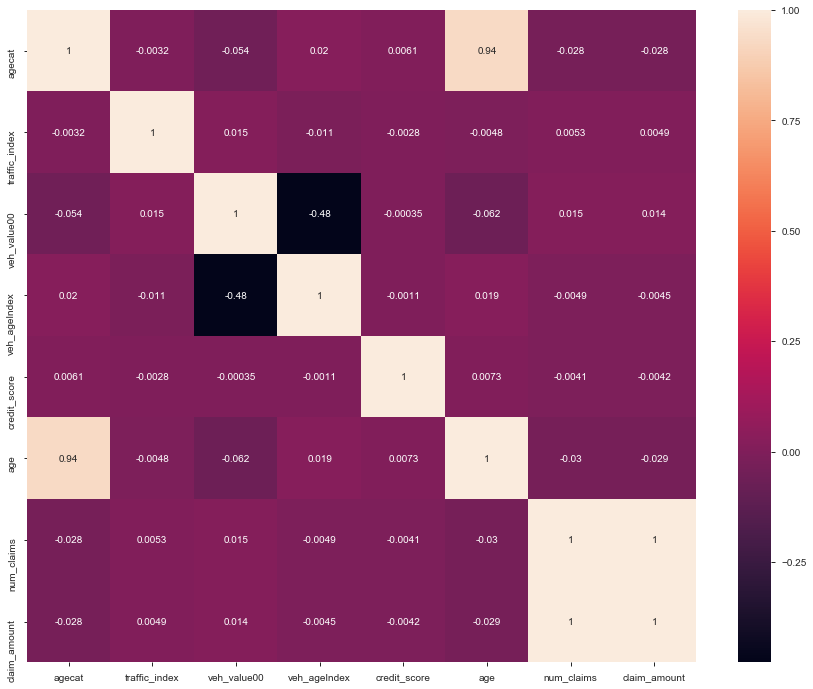

In [80]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), annot=True)

**Split data set between categorical and continuous to check distributions** which should help us decide which features to drop

I will treat ordinal features as numeric data.  Doing this requires the assumption that the numeric space between each category is equal or close to equal.   To ignore the ordering would essentially mean we could delete columns for the drivers age, the traffic index, vehicle age and credit score; that would be too much useful information to lose and an extreme downside.  The downside to treating this data as numeric is that if the spread between bins are not equal, then our results may only be approximate.  I would posit that the approximate results would be more accurate than any model that disregarded them. 

In [81]:
# create continuous sub-DataFrame

continuous = data.copy()
for i in continuous:
    if continuous[i].dtype.name == 'category':
        continuous.drop(i, axis=1, inplace = True)
continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 8 columns):
agecat           60948 non-null int64
traffic_index    60948 non-null int64
veh_value00      60948 non-null float64
veh_ageIndex     60948 non-null int64
credit_score     60948 non-null int64
age              60948 non-null int64
num_claims       60948 non-null int64
claim_amount     60948 non-null float64
dtypes: float64(2), int64(6)
memory usage: 3.7 MB


In [82]:
continuous.head()

,agecat,traffic_index,veh_value00,veh_ageIndex,credit_score,age,num_claims,claim_amount
0,4,93,2.96,4,52,53,0,0.0
1,3,108,1.89,4,83,38,0,0.0
2,5,100,2.75,3,71,56,0,0.0
3,3,77,2.92,3,81,41,0,0.0
4,2,100,3.63,4,88,31,0,0.0


In [83]:
continuous.num_claims.value_counts()

0    56787
1     3907
2      236
3       17
4        1
Name: num_claims, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000208CED452B0>,
      dtype=object)

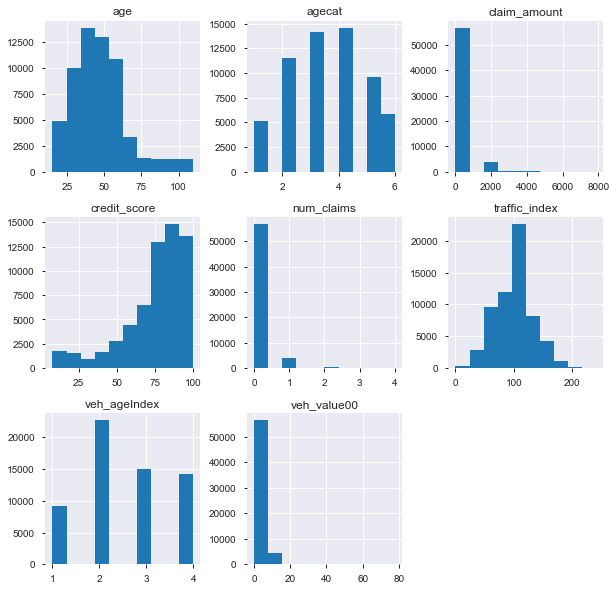

In [84]:
# inspect distributions for continuous data
continuous.hist(figsize=(10,10))

we have colinearity between:
- age & agecat
- num_claims & claim_amount  
lets drop age since agecat looks like a better distribution.  
claim amount and num_claims end up distorting the models so lets drop them both. 

In [85]:
def print_value_counts(df):
    
    for col in df:
        print(col,':')
        print(df[col].value_counts(),'\n')
print_value_counts(continuous)

agecat :
4    14585
3    14177
2    11539
5     9634
6     5853
1     5160
Name: agecat, dtype: int64 

traffic_index :
100    12760
76       562
72       558
84       544
77       544
       ...  
232        1
218        1
221        1
222        1
223        1
Name: traffic_index, Length: 228, dtype: int64 

veh_value00 :
3.38     7942
3.06      436
1.59      419
2.92      411
3.15      403
         ... 
52.64       1
20.45       1
14.57       1
17.97       1
25.29       1
Name: veh_value00, Length: 825, dtype: int64 

veh_ageIndex :
2    22653
3    15005
4    14148
1     9142
Name: veh_ageIndex, dtype: int64 

credit_score :
81    4511
87    1786
88    1772
91    1739
85    1714
      ... 
26      87
28      85
25      80
21      80
8        1
Name: credit_score, Length: 90, dtype: int64 

age :
49     1506
51     1503
54     1502
53     1498
43     1498
       ... 
93      106
75      105
84      104
109     101
110      67
Name: age, Length: 96, dtype: int64 

num_claims :
0    56

In [86]:
# log transform
cont_log = np.log(continuous)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [87]:
cont_log.num_claims.value_counts()

-inf         56787
 0.000000     3907
 0.693147      236
 1.098612       17
 1.386294        1
Name: num_claims, dtype: int64

In [88]:
cont_log.replace(-np.inf, np.nan, inplace=True)
cont_log.replace(np.nan, 0, inplace=True)

In [89]:
cont_log.num_claims.value_counts()

0.000000    60694
0.693147      236
1.098612       17
1.386294        1
Name: num_claims, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000208D5D0C9B0>,
      dtype=object)

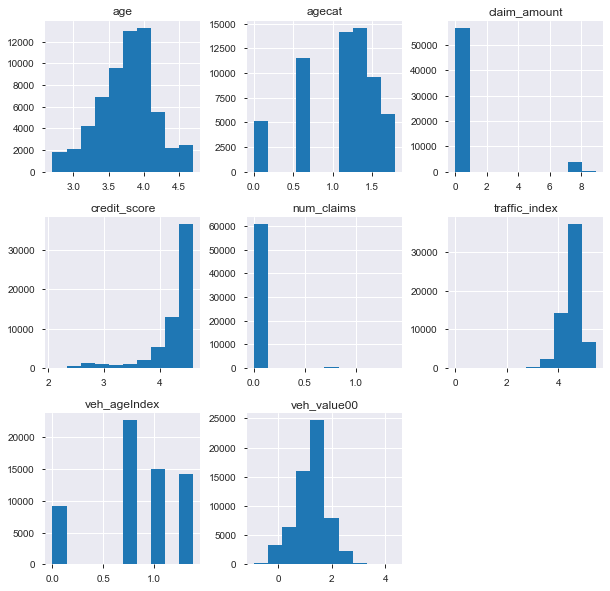

In [90]:
# inspect distributions for continuous data
cont_log.hist(figsize=(10,10))

veh_value, claim_amount and num_claims are so heavily skewed that it doesnt make sense to keep the columns.  In addition, the multicolinearity presents a problem.

In [91]:
cont_log.head()

,agecat,traffic_index,veh_value00,veh_ageIndex,credit_score,age,num_claims,claim_amount
0,1.386294,4.532599,1.085189,1.386294,3.951244,3.970292,0.0,0.0
1,1.098612,4.682131,0.636577,1.386294,4.418841,3.637586,0.0,0.0
2,1.609438,4.605170,1.011601,1.098612,4.262680,4.025352,0.0,0.0
3,1.098612,4.343805,1.071584,1.098612,4.394449,3.713572,0.0,0.0
4,0.693147,4.605170,1.289233,1.386294,4.477337,3.433987,0.0,0.0


**remove features causing multicolinearity**

In [92]:
cont_log.drop(['num_claims', 'claim_amount', 'veh_value00', 'agecat'],axis=1, inplace=True)

In [93]:
# create categorical sub-DataFrame

categorical = data.copy()
for i in categorical:
    if categorical[i].dtype.name != 'category':
        categorical.drop(i, axis = 1, inplace=True)
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 239.0 KB


**Get Dummies for categorical data**

In [94]:
categorical.head()

,gender,area,claim_ind,veh_body2
0,M,C,0,STNWG
1,M,C,0,SEDAN
2,M,A,0,SEDAN
3,M,B,0,UTE
4,M,D,0,STNWG


In [95]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 239.0 KB


In [96]:
categorical.veh_body2.value_counts()

SEDAN    19981
HBACK    16966
STNWG    14646
UTE       4108
TRUCK     1576
HDTOP     1506
MIBUS      794
COUPE      704
PANVN      667
Name: veh_body2, dtype: int64

In [97]:
# one-hot encode categorical data
dummies = pd.get_dummies(categorical.drop('claim_ind', axis=1))
dummies.head()

,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [98]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 17 columns):
gender_F           60948 non-null uint8
gender_M           60948 non-null uint8
area_A             60948 non-null uint8
area_B             60948 non-null uint8
area_C             60948 non-null uint8
area_D             60948 non-null uint8
area_E             60948 non-null uint8
area_F             60948 non-null uint8
veh_body2_COUPE    60948 non-null uint8
veh_body2_HBACK    60948 non-null uint8
veh_body2_HDTOP    60948 non-null uint8
veh_body2_MIBUS    60948 non-null uint8
veh_body2_PANVN    60948 non-null uint8
veh_body2_SEDAN    60948 non-null uint8
veh_body2_STNWG    60948 non-null uint8
veh_body2_TRUCK    60948 non-null uint8
veh_body2_UTE      60948 non-null uint8
dtypes: uint8(17)
memory usage: 1012.0 KB


**concat the continuous and categorical DataFrames**

this df:  
- log transformed 
- multicolinearity removed

In [99]:
#beginning processed dataframe
df = pd.concat([cont_log, dummies, categorical.claim_ind], axis = 1, sort=False)
df.head()

,traffic_index,veh_ageIndex,credit_score,age,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,4.532599,1.386294,3.951244,3.970292,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,4.682131,1.386294,4.418841,3.637586,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,4.605170,1.098612,4.262680,4.025352,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4.343805,1.098612,4.394449,3.713572,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4.605170,1.386294,4.477337,3.433987,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


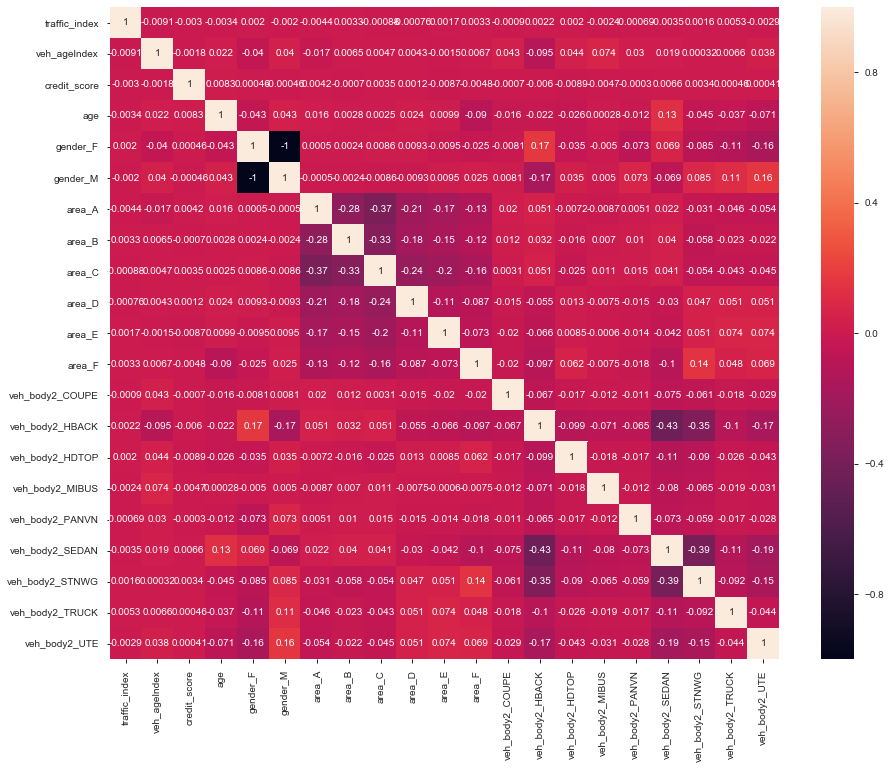

In [100]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True)

In [101]:
df.claim_ind.value_counts()

0    56787
1     4161
Name: claim_ind, dtype: int64

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 22 columns):
traffic_index      60948 non-null float64
veh_ageIndex       60948 non-null float64
credit_score       60948 non-null float64
age                60948 non-null float64
gender_F           60948 non-null uint8
gender_M           60948 non-null uint8
area_A             60948 non-null uint8
area_B             60948 non-null uint8
area_C             60948 non-null uint8
area_D             60948 non-null uint8
area_E             60948 non-null uint8
area_F             60948 non-null uint8
veh_body2_COUPE    60948 non-null uint8
veh_body2_HBACK    60948 non-null uint8
veh_body2_HDTOP    60948 non-null uint8
veh_body2_MIBUS    60948 non-null uint8
veh_body2_PANVN    60948 non-null uint8
veh_body2_SEDAN    60948 non-null uint8
veh_body2_STNWG    60948 non-null uint8
veh_body2_TRUCK    60948 non-null uint8
veh_body2_UTE      60948 non-null uint8
claim_ind          60948 non-null category


create the training and test data we will use for this notebook using **.sample()** instead of SMOTE

In [103]:
features_X = df[df.columns[0:-1]].copy()
target_y = df.claim_ind.copy()

# Logistic Regression Models

## LR Model 1

In [104]:
logReg = LogisticRegression()

scores = cross_val_score(logReg, features_X, target_y,
                         scoring= 'roc_auc' , cv=10)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

In [105]:
type(scores)

numpy.ndarray

In [106]:
scores

array([0.52506753, 0.54717575, 0.53493937, 0.55135126, 0.51684428,
       0.53537408, 0.52249135, 0.54270023, 0.56492586, 0.5221219 ])

In [107]:
from numpy import savetxt

In [108]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())
    #savetxt('scores.csv', scores)
display_scores(scores)

Scores: [0.52506753 0.54717575 0.53493937 0.55135126 0.51684428 0.53537408
 0.52249135 0.54270023 0.56492586 0.5221219 ]
Mean: 0.5362991612424198
Standard Deviation: 0.01450628996369617


In [109]:
def gini_scores(scores):
    gini_list = []
    
    for score in scores:
        gini = (2 * score) -1
        gini_list.append(gini)

    gini_list = np.asarray(gini_list)
    return gini_list.mean()  

In [110]:
mean_gini_LogReg = gini_scores(scores)

In [111]:
print(f'mean gini score for logistic regression: {mean_gini_LogReg:0.3}')

mean gini score for logistic regression: 0.0726


In [112]:
%whos

Variable                 Type                          Data/Info
----------------------------------------------------------------
ADASYN                   ABCMeta                       <class 'imblearn.over_sampling._adasyn.ADASYN'>
BaggingClassifier        ABCMeta                       <class 'sklearn.ensemble.<...>gging.BaggingClassifier'>
GridSearchCV             ABCMeta                       <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LogisticRegression       type                          <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
NamespaceMagics          MetaHasTraits                 <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
OneHotEncoder            type                          <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
RF_scores                ndarray                       10: 10 elems, type `float64`, 80 bytes
RandomForestClassifier   ABCMeta                       <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SMOTE  

# Random Forest Models

## RF Model 1

In [113]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
RF_scores = cross_val_score(forest, features_X, target_y, scoring='roc_auc', cv=10)

In [114]:
display_scores(RF_scores)

Scores: [0.53677628 0.54398797 0.53735485 0.55361415 0.50761535 0.53093042
 0.53063115 0.52997822 0.56094499 0.52701385]
Mean: 0.5358847249862666
Standard Deviation: 0.014056493549048895


In [115]:
mean_RF_gini = gini_scores(RF_scores)
print(f'mean gini score for random forest: {mean_RF_gini:0.3}')

mean gini score for random forest: 0.0718


In [121]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, features_X, target_y, cv=10))

print(f'Mean cross validation gini index for random forest classifier: {mean_rf_cv_score:0.4}')
                
                           

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mngav\A

Mean cross validation gini index for random forest classifier: 0.9285


# XGBoost Models

## XGBoost Model 1

In [122]:
%%time
boost_clf = xgb.XGBClassifier()
boost_scores = cross_val_score(boost_clf, features_X, target_y, scoring='roc_auc', cv=10)

Wall time: 24.7 s


In [123]:
display_scores(boost_scores)

Scores: [0.52611392 0.54194858 0.52167335 0.52962839 0.51178431 0.53860821
 0.52418069 0.52953983 0.5445571  0.51023773]
Mean: 0.5278272084677984
Standard Deviation: 0.011057018221584971


In [124]:
mean_boost = gini_scores(boost_scores)
print(f'mean gini score for XGBoost: {mean_boost:0.3}')

mean gini score for XGBoost: 0.0557


In [125]:
xg_param_grid = {
    
    "learning_rate": [0.1],
    'max_depth': [7],
    'min_child_weight': [9],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250, 500],
    }

Wall time: 0 ns


In [ ]:
xg_grid_search = GridSearchCV(boost_clf, xg_param_grid, cv=10)
xg_grid_search.fit(features_X, target_y)

print(f'testing )

**XGBoost Classification Report**

In [120]:
print(classification_report(y_test_boost, test_preds))

NameError: name 'y_test_boost' is not defined

# Future Work

https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html  
https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
